In [31]:
import numpy as np 
import pandas as pd 
import numpy as np 
import pandas as pd
import xarray as xr
import openpyxl
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import *
import matplotlib.colors as colors
from scipy import stats 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point


In [32]:

#Bazard utile 

iyr=2000
fyr=2023
domain='GRa'
domainO='MARMer'
variable='pr'
var='pr'
units='mm/month'
exp='obs'

model1='MAR'
res1='5x5km'

model2='chirps'
res2='0.05°x0.05°'

model3='cru'

model4='aphro'
res4=str('0.25°x0.25°')

model5='gpcp'
res5=str('1.0°x1.0°')
model6='era5-land'

model7='era5'

titles = {
    'MAM': 'MAM',
    'JJAS': 'JJAS',
    'ON': 'ON',
    'DJF': 'DJF',
}

seasons = ['MAM', 'JJAS', 'ON', 'DJF']

station='Naulek'


Heraland= 5052
Hera5= 5207
Hcru= 3987

#Glacioclim station location

lon_Station_Glacioclim=86.89739046
lat_Station_Glacioclim=27.71772341
elev_Station_Glacioclim=5350.000


In [33]:
## GRID Model MAR
sourceDataGrid='/home/amoryc/'
#fileName_grF='NST.2000.01.01.00.GRa_Fedchenko.nc'
fileName_grM='NST.2000.01.01.00.GRa_Mera.nc_ICEmask'
ds_grM= xr.open_dataset(sourceDataGrid+fileName_grM)

In [34]:
sourceData1='/bettik/PROJECTS/pr-regional-climate/santolam/'
sourceData2='/bettik/PROJECTS/pr-regional-climate/fainx/'

In [35]:
####
## MAR
####
sourceDataMAR='/bettik/PROJECTS/pr-regional-climate/santolam/MARout/GRa/spin2/work/monthly/'
variable='TTZ' ##RF;SF;SHSN3;TT
fileName1='TTZ_mon_MARv3.14_ER5_spin2_GRa_2000-2023.nc' ##change to monthly
dsM= xr.open_dataset(sourceDataMAR+fileName1)['TTZ'][:,1,:,:] ## montlhy mean
FieldMAR = dsM.rename({'TIME': 'time'})

In [36]:
####
## CRU
####

res3=str('0.5°x0.5°')

fileName3='cru_ts4.05.1901.2020.tmp.dat_remapMARMer.nc'
ds3 = xr.open_dataset(sourceData1+model3+'/'+fileName3)['tmp']
FieldCRU=ds3.sel(time=slice(str(iyr)+'-01',str(fyr)+'-12'))
#units in mm/month -> mm/day
#field50=dom.field_dom(ds5,domain)
#month_length5 = field50.time.dt.days_in_month
#
#field5=field50/month_length5

FieldCRU=FieldCRU.rename({'lat': 'lat3'})
FieldCRU=FieldCRU.rename({'lon': 'lon3'})

In [37]:
######
## ERA-5 LAND
######

fileName6='era5-land_t2m_remap_GRa.nc'
ds6 = xr.open_dataset(sourceData2+model6+'/'+fileName6)['t2m']

FieldERALAND=ds6.sel(valid_time=slice(str(iyr)+'-01',str(fyr)+'-12'))
#units in mm/month -> mm/day
#field50=dom.field_dom(ds5,domain)
#month_length5 = field50.time.dt.days_in_month
#
#field5=field50/month_length5
FieldERALAND=FieldERALAND.rename({'valid_time': 'time'})
FieldERALAND=FieldERALAND.rename({'lat': 'lat6'})
FieldERALAND=FieldERALAND.rename({'lon': 'lon6'})




In [38]:
######
## ERA-5 
######

fileName7='era5_t2m_remap_GRa.nc'
ds7 = xr.open_dataset(sourceData2+model7+'/'+fileName7)['t2m']
FieldERA_5=ds7.sel(valid_time=slice(str(iyr)+'-01',str(fyr)+'-12'))
#units in mm/month -> mm/day
#field50=dom.field_dom(ds5,domain)
#month_length5 = field50.time.dt.days_in_month
#
#field5=field50/month_length5
FieldERA_5=FieldERA_5.rename({'valid_time': 'time'})
FieldERA_5=FieldERA_5.rename({'lat': 'lat7'})
FieldERA_5=FieldERA_5.rename({'lon': 'lon7'})


In [39]:
#####
## Opening station data + Deff Var 
#####
path="/bettik/PROJECTS/pr-regional-climate/santolam/glacioclim/donnees_meteo/Naulekfinal2012_24.xlsx"
xl_data=pd.ExcelFile(path)                           
df= {sheet_name: xl_data.parse(sheet_name)     
       for sheet_name in xl_data.sheet_names}
Data=df['Naulekfinal2012_24']                  
NameVars=['Time','Tairlow','RHlow','Tairhight','RHhight','u','Direction','SWin','SWout','LWincor','LWoutcor','Abl/acc dist sensor surf','tilt metter XAXIS','tilt meter YAXIX']
UnitVars=['data/hour','C','%','C','%','m/s','degrees','W/m2','W/m2','W/m2','W/m2','m','degrees','degrees']

##Define new DataFrame and changing name of columns
dfile= pd.DataFrame(data=Data.loc[4:]) 
df=pd.DataFrame(dfile.values, columns=NameVars) 
### Opening one column + converting into an array
Tairlow_ar=[float(i) for i in df.Tairlow.values]   #Convertit les données en float utilisables 
Tairhight_ar=[float(i) for i in df.Tairhight.values] 
#Pour l'utilisation des données avec xarray, redéfinitions des variables en prenant en compte la fréquence à laquelle les données sont prises ( ici 30 min ) 
def NewTime(
        NameVar,
        Var_ar,
        freq):
    start, end = df.Time.values[0], df.Time.values[-1]
    time = pd.date_range(start, end, freq=freq)
    ds = xr.Dataset({NameVar: ("time",np.asarray(Var_ar)), "time": time})
    return ds 
    
Tlow=NewTime('Tairlow',Tairlow_ar,'30min')
Thight=NewTime('Tairhight',Tairhight_ar,'30min')
T=xr.Dataset()
T['Tair']=Tlow.Tairlow
#T['Tair']=Thight.Tairhight#faire égal à ça si différent de Nan et égal à Tlow sinon.
#T['Tair']= ((Tlow.Tairlow+Thight.Tairhight)/2) #faire égal à ça si différent de Nan et égal à Tlow sinon.

In [40]:
######
## Finding Pixel MAR (i,j)
######



##Find the pixel of MAR corresponding to station
target_lon = lon_Station_Glacioclim
target_lat = lat_Station_Glacioclim
lon=ds_grM.LON
lat=ds_grM.LAT


#Step 2: Find the nearest grid point to target_lon,target_lat
# Compute distance to each grid point
dist = np.sqrt((lon - target_lon)**2 + (lat - target_lat)**2)
#print(dist)
j, i = np.unravel_index(dist.argmin(), dist.shape)

#Step 3: Extract data at that location
# For a single time step
#value = dsM['SH'].isel(y=j, x=i)
## If there's a time dimension
dsM_MAR=FieldMAR[0:, j, i]

#units=dsM.units

#BONUS FOR MAR
SH_sta=elev_Station_Glacioclim
value = ds_grM['SH'].isel(y=j, x=i)
diff=SH_sta-value.values
value.values,SH_sta, diff
print(j,i)
print(diff)
print(SH_sta)

39 99
285.87256
5350.0


In [41]:
######
## Finding Pixel CRU (m,n)
######
##Find the pixel of Chirps corresponding to station
target_lon = lon_Station_Glacioclim
target_lat = lat_Station_Glacioclim
lon3=FieldCRU.lon3
lat3=FieldCRU.lat3
#Step 2: Find the nearest grid point to target_lon,target_lat
# Compute distance to each grid point
dist = np.sqrt((lon3 - target_lon)**2 + (lat3 - target_lat)**2)
n, m = np.unravel_index(dist.argmin(), dist.shape)
print(n,m)
#Step 3: Extract data at that location
# For a single time step
#value = dsM['SH'].isel(y=j, x=i)
## If there's a time dimension

dsM_CRU=FieldCRU[0:, n, m]

39 99


In [42]:
######
## Finding Pixel ERA-5 LAND (o,p)
######
##Find the pixel of Chirps corresponding to station
target_lon = lon_Station_Glacioclim
target_lat = lat_Station_Glacioclim
lon6=FieldERALAND.lon6
lat6=FieldERALAND.lat6
#Step 2: Find the nearest grid point to target_lon,target_lat
# Compute distance to each grid point
dist = np.sqrt((lon6 - target_lon)**2 + (lat6 - target_lat)**2)
p, o = np.unravel_index(dist.argmin(), dist.shape)
print(p,o)
#Step 3: Extract data at that location
# For a single time step
#value = dsM['SH'].isel(y=j, x=i)
## If there's a time dimension

dsM_ERALAND1=FieldERALAND[0:, p, o]
dsM_ERALAND=dsM_ERALAND1
dsM_ERALAND.values=dsM_ERALAND1.values -273.15

39 99


In [43]:
######
## Finding Pixel ER-5 (q,r)
######
##Find the pixel of Chirps corresponding to station
target_lon = lon_Station_Glacioclim
target_lat = lat_Station_Glacioclim
lon7=FieldERA_5.lon7
lat7=FieldERA_5.lat7
#Step 2: Find the nearest grid point to target_lon,target_lat
# Compute distance to each grid point
dist = np.sqrt((lon7 - target_lon)**2 + (lat7 - target_lat)**2)
r, q = np.unravel_index(dist.argmin(), dist.shape)
print(r,q)
#Step 3: Extract data at that location
# For a single time step
#value = dsM['SH'].isel(y=j, x=i)
## If there's a time dimension

dsM_ERA_51=FieldERA_5[0:, r, q]
dsM_ERA_5=dsM_ERA_51
dsM_ERA_5.values=dsM_ERA_51.values -273.15

39 99


In [44]:
######
## Definition fonctions
######


#Définition des Saisons, et création d'une fonction qui définit les saisons en fonction des périodes des moussons:
seasons = {
	'MAM': [3, 4, 5],  	
	'JJAS': [6, 7, 8, 9],  
	'ON': [10, 11],    	
	'DJF': [12, 1, 2]  	
}
def seasonsdata(ds, season_name): 
	x = seasons[season_name]
	return ds.sel(time=ds['time'].dt.month.isin(x))

#Fonction Clim de base 

#Util pour les Températures exprimées dans les fichiers glacioclim
def Clim_mean(ds, variable):
    daily = ds[variable].resample(time='D').mean()
    monthly = daily.resample(time='ME').mean()
    yearly = monthly.resample(time='YE').mean()

    return {
        'daily': daily.to_dataset(name=variable),
        'monthly': monthly.to_dataset(name=variable),
        'yearly': yearly.to_dataset(name=variable)
    }

#Util pour les Précips exprimées dans les fichiers glacioclim
def Clim_sum(ds, variable):
    daily = ds[variable].resample(time='D').sum()
    monthly = daily.resample(time='ME').sum()
    yearly = monthly.resample(time='YE').sum()

    return {
        'daily': daily.to_dataset(name=variable),
        'monthly': monthly.to_dataset(name=variable),
        'yearly': yearly.to_dataset(name=variable)
    }


# Precip sta classic climatic variables. Donne un DataArray, Timeseries des moyennes de précip saisonnières sur la période considérée

def seasonal_annual_clim(datasets, seasons):

    return {
        name: {
            season: seasonsdata(ds, season).resample(time='YE').mean()
            for season in seasons
        }
        for name, ds in datasets.items()
    }

#Même fonction mais pour les données des Models considérés.
def Model_seasonal_timeseries(ds, model_name='Chirps'):
    # Suffixes pour noms de variable
    suffix_map = {
        'MAM': 'premon',
        'JJAS': 'mon',
        'ON': 'postmon',
        'DJF': 'hiver'
    }

    seasonal_dict = {}

    for season, suffix in suffix_map.items():
        ts = seasonsdata(ds, season).resample(time='YE').mean()
        var_name = f'Timeseries_{model_name}_{suffix}'
        globals()[var_name] = ts  # Création de la variable globale
        seasonal_dict[season] = ts

    return seasonal_dict

In [45]:
######
## Premier Traitement climato
######

In [46]:
#Précip station
Clim_Temp_station=Clim_mean(T,'Tair')
#définition temps commun pour toutes les données ( bordés sur celle de station en entrée, et la première donnée à manquer en sortie[aussi station])

time1 = Clim_Temp_station['monthly']['time']# début 
start=time1[0] 
end=time1[-1]




T_sta=Clim_Temp_station['monthly'].sel(time=slice(start,end))
T_MAR=dsM_MAR.sel(time=slice(start,end))

T_CRU=dsM_CRU.sel(time=slice(start,end))

T_ERA_5_LAND=dsM_ERALAND.sel(time=slice(start,end))

T_ERA_5=dsM_ERA_5.sel(time=slice(start,end))


In [47]:
#Précip station suite

ClimBasis_T_station=Clim_mean(T,'Tair')

seasonal_T_station= seasonal_annual_clim(T_sta, seasons)

T_cycle_sta=ClimBasis_T_station['monthly'].groupby('time.month').mean()


In [48]:
#Précip Models
#Seasonnal
seasonnal_T_MAR=Model_seasonal_timeseries(T_MAR)

seasonnal_T_CRU=Model_seasonal_timeseries(T_CRU)

seasonnal_T_ERA_5_LAND=Model_seasonal_timeseries(T_ERA_5_LAND)

seasonnal_T_ERA_5=Model_seasonal_timeseries(T_ERA_5)
#Annual cycle

T_MAR_cycle=T_MAR.groupby('time.month').mean()
T_CRU_Cycle=T_CRU.groupby('time.month').mean()
T_ERA_5_LAND_Cycle=T_ERA_5_LAND.groupby('time.month').mean()
T_ERA_5_Cycle=T_ERA_5.groupby('time.month').mean()

In [49]:
diffcru= elev_Station_Glacioclim-Hcru
differa5=elev_Station_Glacioclim-Hera5
differa5land=elev_Station_Glacioclim-Heraland

In [50]:
####
## MAR correction
####
TLR0 = np.array([
    -0.006242526319631822,
    -0.006626033401296663,
    -0.006926541743521814,
    -0.006811935473776589,
    -0.006122552591291037,
    -0.005310550287924041,
    -0.0047134763511124346,
    -0.004796637882985849,
    -0.005148371260569886,
    -0.0060408092593950795,
    -0.006209976271156402,
    -0.006062370122908506
])
TLR_MAR=np.array([])
TLR_MAR=diff*TLR0

TLR_MAR_premon=np.array([
   -0.006926541743521814,
    -0.006811935473776589,
    -0.006122552591291037
]).mean()

TLR_MAR_mon=np.array([
    -0.005310550287924041,
    -0.0047134763511124346,
    -0.004796637882985849,
    -0.005148371260569886
]).mean()

TLR_MAR_postmon=np.array([
   -0.0060408092593950795,
    -0.006209976271156402
]).mean()

TLR_MAR_winter=np.array([
   -0.006062370122908506,
     -0.006242526319631822,
    -0.006626033401296663
]).mean()





# Correction mensuelle 
TLR_correction = xr.DataArray(TLR_MAR, coords={"month": np.arange(1, 13)}, dims="month")
Corrected_T_MAR_cycle = T_MAR_cycle + TLR_correction

#Correction sur les données saisonières :


TLR_by_season = {    
    'DJF': TLR_MAR_winter,
    'MAM': TLR_MAR_premon,
    'JJAS': TLR_MAR_mon,
    'ON': TLR_MAR_mon,
}

seasonnal_T_MAR_corrected = {}

for season, data_array in seasonnal_T_MAR.items():
    tlr_correction = TLR_by_season[season]

    corrected_array = data_array + tlr_correction*diff
    
    seasonnal_T_MAR_corrected[season] = corrected_array
    



In [51]:
####
## CRU correction
####
TLR0_CRU = np.array([
    -0.004175075767590449,
    -0.004469196142233335,
    -0.004801063039669624,
    -0.005043384825633122,
    -0.0051280019645966015,
    -0.004713512461735652,
    -0.004211140990624061,
    -0.004082430185171274,
    -0.004120462270883414,
    -0.004516066878036811,
    -0.004506014701403104,
    -0.004107983516729795
])
TLR_CRU = diffcru * TLR0_CRU

# Moyennes saisonnières pour CRU
TLR_CRU_premon = np.array([
    -0.004801063039669624,
    -0.005043384825633122,
    -0.0051280019645966015
]).mean()

TLR_CRU_mon = np.array([
    -0.004713512461735652,
    -0.004211140990624061,
    -0.004082430185171274,
    -0.004120462270883414
]).mean()

TLR_CRU_postmon = np.array([
    -0.004516066878036811,
    -0.004506014701403104
]).mean()

TLR_CRU_winter = np.array([
    -0.004107983516729795,
    -0.004175075767590449,
    -0.004469196142233335
]).mean()
# Correction mensuelle CRU
TLR_CRU_correction = xr.DataArray(TLR_CRU, coords={"month": np.arange(1, 13)}, dims="month")
Corrected_T_CRU_Cycle = T_CRU_Cycle + TLR_CRU_correction

# Correction saisonnière CRU
TLR_CRU_by_season = {
    'DJF': TLR_CRU_winter,
    'MAM': TLR_CRU_premon,
    'JJAS': TLR_CRU_mon,
    'ON': TLR_CRU_mon,
}
seasonnal_T_CRU_corrected = {}

for season, data_array in seasonnal_T_CRU.items():
    tlr_correction = TLR_CRU_by_season[season]
    corrected_array = data_array + tlr_correction * diffcru
    seasonnal_T_CRU_corrected[season] = corrected_array


In [52]:
####
## ERA-5-LAND correction
####


TLR0_ERA5_land = np.array([
    -0.0061231811608586555,
    -0.006486978536073256,
    -0.006640442439975606,
    -0.006398903646953199,
    -0.005702959253570847,
    -0.0047674171736664436,
    -0.004301166481275325,
    -0.004413596391386167,
    -0.0047833200284142134,
    -0.00558397902710424,
    -0.005810460526723116,
    -0.005749365008261902
])
TLR_ERA5_land = differa5 * TLR0_ERA5_land

# Moyennes saisonnières ERA5-land
TLR_ERA5_land_premon = np.array([
    -0.006640442439975606,
    -0.006398903646953199,
    -0.005702959253570847
]).mean()

TLR_ERA5_land_mon = np.array([
    -0.0047674171736664436,
    -0.004301166481275325,
    -0.004413596391386167,
    -0.0047833200284142134
]).mean()

TLR_ERA5_land_postmon = np.array([
    -0.00558397902710424,
    -0.005810460526723116
]).mean()

TLR_ERA5_land_winter = np.array([
    -0.005749365008261902,
    -0.0061231811608586555,
    -0.006486978536073256
]).mean()

# Correction mensuelle ERA5-Land
TLR_ERA5_land_correction = xr.DataArray(TLR_ERA5_land, coords={"month": np.arange(1, 13)}, dims="month")
Corrected_T_ERA5_Land_Cycle = T_ERA_5_LAND_Cycle + TLR_ERA5_land_correction

# Correction saisonnière ERA5-Land
TLR_ERA5_land_by_season = {
    'DJF': TLR_ERA5_land_winter,
    'MAM': TLR_ERA5_land_premon,
    'JJAS': TLR_ERA5_land_mon,
    'ON': TLR_ERA5_land_mon,
}
seasonnal_T_ERA5_land_corrected = {}

for season, data_array in seasonnal_T_ERA_5_LAND.items():
    tlr_correction = TLR_ERA5_land_by_season[season]
    corrected_array = data_array + tlr_correction * differa5
    seasonnal_T_ERA5_land_corrected[season] = corrected_array


In [53]:
####
## ERA-5 correction
####
TLR0_ERA5 = np.array([
    -0.00547501694392573,
    -0.005787563082935429,
    -0.006364022399212336,
    -0.006666844328611224,
    -0.006542200533844217,
    -0.005932956977254833,
    -0.005267873942033374,
    -0.005025458090259408,
    -0.005137903164956808,
    -0.005729139120186048,
    -0.005875394525155932,
    -0.005438179475470423
])
TLR_ERA5 = differa5land * TLR0_ERA5

# Moyennes saisonnières ERA5
TLR_ERA5_premon = np.array([
    -0.006364022399212336,
    -0.006666844328611224,
    -0.006542200533844217
]).mean()

TLR_ERA5_mon = np.array([
    -0.005932956977254833,
    -0.005267873942033374,
    -0.005025458090259408,
    -0.005137903164956808
]).mean()

TLR_ERA5_postmon = np.array([
    -0.005729139120186048,
    -0.005875394525155932
]).mean()

TLR_ERA5_winter = np.array([
    -0.005438179475470423,
    -0.00547501694392573,
    -0.005787563082935429
]).mean()

# Correction mensuelle ERA5
TLR_ERA5_correction = xr.DataArray(TLR_ERA5, coords={"month": np.arange(1, 13)}, dims="month")
Corrected_T_ERA5_Cycle = T_ERA_5_Cycle + TLR_ERA5_correction

# Correction saisonnière ERA5
TLR_ERA5_by_season = {
    'DJF': TLR_ERA5_winter,
    'MAM': TLR_ERA5_premon,
    'JJAS': TLR_ERA5_mon,
    'ON': TLR_ERA5_mon,
}
seasonnal_T_ERA5_corrected = {}

for season, data_array in seasonnal_T_ERA_5.items():
    tlr_correction = TLR_ERA5_by_season[season]
    corrected_array = data_array + tlr_correction * differa5land
    seasonnal_T_ERA5_corrected[season] = corrected_array


In [54]:
###########
## BIAIS ##
###########

################################# Saisonnier
products = ['MAR', 'MARc', 'CRU', 'CRUc', 'ERA5land', 'ERA5landc', 'ERA5', 'ERA5c']
bias_data = {prod: [] for prod in products}

# Calcul du biais pour chaque saison et chaque produit
for season in seasons:
    sta = seasonal_T_station['Tair'][season]

    # Produits climatiques (non corrigés et corrigés)
    mar = seasonnal_T_MAR[season]
    mar_corr = seasonnal_T_MAR_corrected[season]

    cru = seasonnal_T_CRU[season]
    cru_corr = seasonnal_T_CRU_corrected[season]

    era5land = seasonnal_T_ERA_5_LAND[season]
    era5land_corr = seasonnal_T_ERA5_land_corrected[season]

    era5 = seasonnal_T_ERA_5[season]
    era5_corr = seasonnal_T_ERA5_corrected[season]

    bias_data['MAR'].append(round(mar.mean().values - sta.mean().values, 2))
    bias_data['MARc'].append(round(mar_corr.mean().values - sta.mean().values, 2))

    bias_data['CRU'].append(round(cru.mean().values - sta.mean().values, 2))
    bias_data['CRUc'].append(round(cru_corr.mean().values - sta.mean().values, 2))

    bias_data['ERA5land'].append(round(era5land.mean().values - sta.mean().values, 2))
    bias_data['ERA5landc'].append(round(era5land_corr.mean().values - sta.mean().values, 2))

    bias_data['ERA5'].append(round(era5.mean().values - sta.mean().values, 2))
    bias_data['ERA5c'].append(round(era5_corr.mean().values - sta.mean().values, 2))

bias_df = pd.DataFrame(bias_data, index=seasons)

print("Tableau du biais saisonnier_"+station+" (produit - station)")
print(bias_df)



################################# Annuel

sta_annual_mean = T_cycle_sta['Tair'].mean().values

bias_annual = {
    'MAR': round(T_MAR_cycle.values.mean() - sta_annual_mean, 2),
    'MARc': round(Corrected_T_MAR_cycle.values.mean() - sta_annual_mean, 2),

    'CRU': round(T_CRU_Cycle.values.mean() - sta_annual_mean, 2),
    'CRUc': round(Corrected_T_CRU_Cycle.values.mean() - sta_annual_mean, 2),

    'ERA5land': round(T_ERA_5_LAND_Cycle.values.mean() - sta_annual_mean, 2),
    'ERA5landc': round(Corrected_T_ERA5_Land_Cycle.values.mean() - sta_annual_mean, 2),

    'ERA5': round(T_ERA_5_Cycle.values.mean() - sta_annual_mean, 2),
    'ERA5c': round(Corrected_T_ERA5_Cycle.values.mean() - sta_annual_mean, 2)
}

bias_annual_df = pd.DataFrame(bias_annual, index=['Annuel'])

print("Tableau du biais annuel_"+station+" (produit - station) ")
print(bias_annual_df)



Tableau du biais saisonnier_Naulek (produit - station)
       MAR  MARc   CRU  CRUc  ERA5land  ERA5landc  ERA5  ERA5c
MAM   0.17 -1.72  8.96  2.16      4.04       3.14  7.13   5.19
JJAS  0.80 -0.62  9.86  4.03      5.24       4.59  8.70   7.11
ON    0.53 -0.89  7.70  1.86      4.48       3.83  7.36   5.77
DJF  -1.17 -2.97  5.68 -0.11      1.94       1.06  3.64   1.98
Tableau du biais annuel_Naulek (produit - station) 
         MAR  MARc   CRU  CRUc  ERA5land  ERA5landc  ERA5  ERA5c
Annuel  0.14 -1.55  8.25  2.13      4.01       3.21  6.84   5.12



###########
## RMSE ## et correlation per season.
###########




#Enlever Cru parce que 1 moins moins pertinent 2 enlève des années de data et era 5/land plus intéressants ? 

#Finalement choix = garder cru

seasonal_T_stationtime2= seasonal_T_station['Tair']['DJF'].sel(time=slice('2014','2023')) 

ProductList=[seasonnal_T_MAR['DJF'],seasonnal_T_MAR_corrected['DJF'],
             seasonnal_T_ERA_5_LAND['DJF'],seasonnal_T_ERA5_land_corrected['DJF'],seasonnal_T_ERA_5['DJF'],
             seasonnal_T_ERA5_corrected['DJF']]
ProductLisT2015= [ds.sel(time=slice('2014','2023')) for ds in ProductList]


corrList=[]
rmseList=[]
for i in range(len(ProductList)):
    tmp=np.corrcoef(seasonal_T_stationtime2.values,ProductLisT2015[i].values)[0,1]
    rmse = np.sqrt(np.nanmean((seasonal_T_stationtime2.values - ProductLisT2015[i].values)**2))
    corrList.append(round(tmp,2))
    rmseList.append(round(rmse,2))



labels = ["MAR", "MARc",  "ERA5land", "ERA5landc", "ERA5", "ERA5c"]

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(corrList, rmseList, marker="x")

# Add experiment labels next to each point
for x, y, label in zip(corrList, rmseList, labels):
    ax.text(x, y, label, fontsize=9, ha="right", va="bottom")

ax.set_xlabel("Correlation")
ax.set_ylabel("RMSE")
ax.set_title("RMSE vs Correlation MeraLa (DJF) ")
ax.grid(True)
fig.tight_layout()




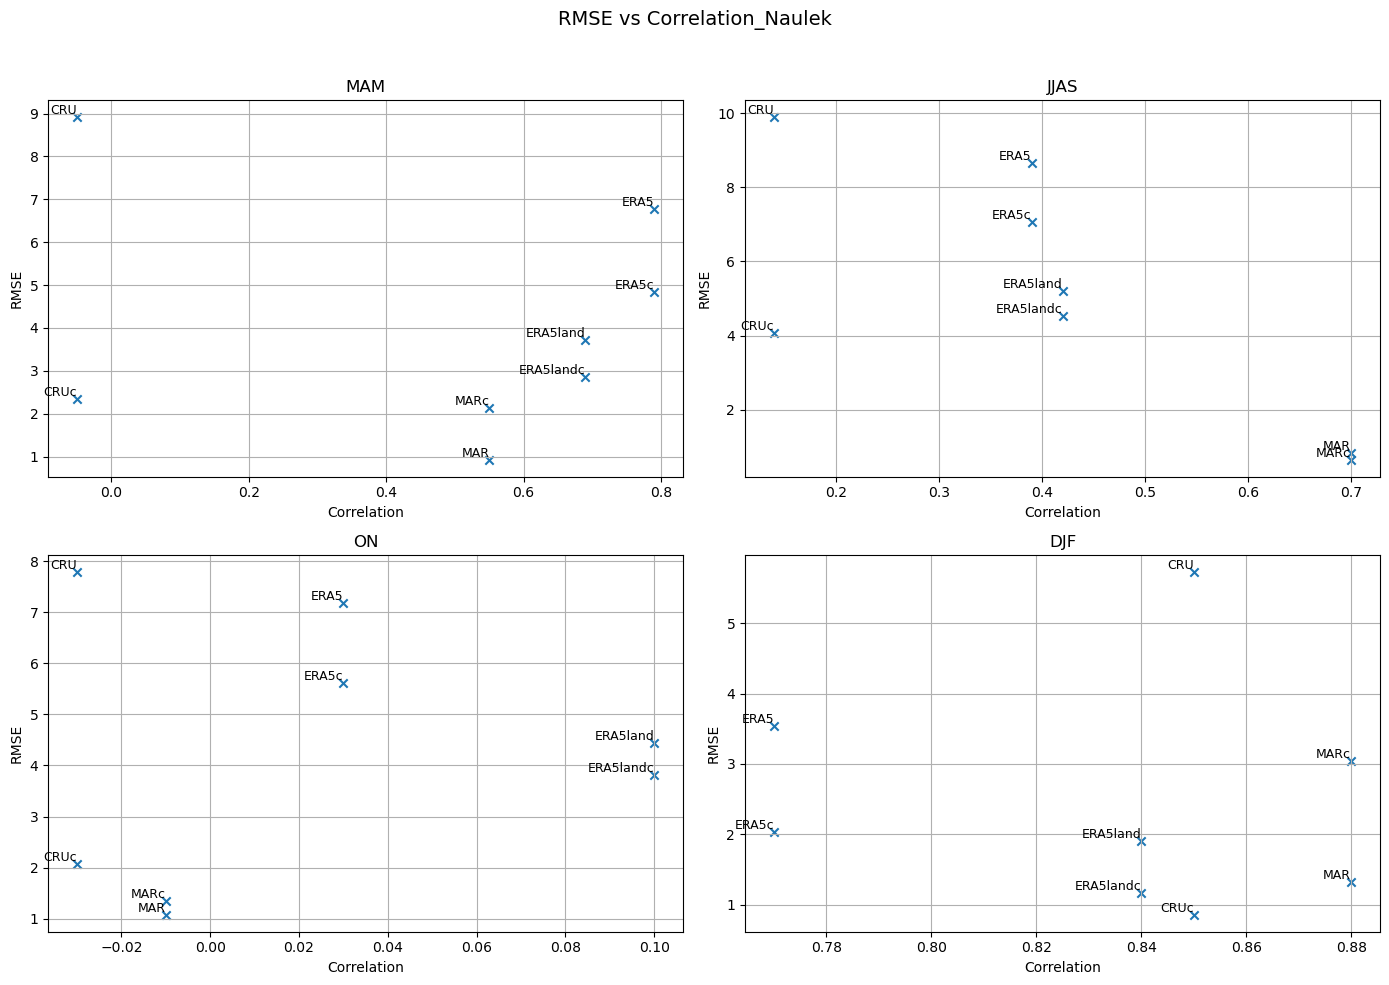

In [55]:

###########
## RMSE ## et correlation per season.
###########

labels = ["MAR", "MARc", "ERA5land", "ERA5landc", "ERA5", "ERA5c","CRU","CRUc"]

# Créer les subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # pour pouvoir indexer plus facilement avec une seule dimension

for idx, season in enumerate(seasons):
    ax = axes[idx]

    # Données d'observation pour la saison
    seasonal_T_stationtime2 = seasonal_T_station['Tair'][season].sel(time=slice('2014', '2020'))

    # Données des produits climatiques pour la saison
    ProductList = [
        seasonnal_T_MAR[season],
        seasonnal_T_MAR_corrected[season],
        seasonnal_T_ERA_5_LAND[season],
        seasonnal_T_ERA5_land_corrected[season],
        seasonnal_T_ERA_5[season],
        seasonnal_T_ERA5_corrected[season],
        seasonnal_T_CRU[season],
        seasonnal_T_CRU_corrected[season]
    ]
    ProductList2015 = [ds.sel(time=slice('2014', '2020')) for ds in ProductList]

    # Calculs
    corrList = []
    rmseList = []
    for product in ProductList2015:
        corr = np.corrcoef(seasonal_T_stationtime2.values, product.values)[0, 1]
        rmse = np.sqrt(np.nanmean((seasonal_T_stationtime2.values - product.values) ** 2))
        corrList.append(round(corr, 2))
        rmseList.append(round(rmse, 2))

    # Plot
    ax.scatter(corrList, rmseList, marker='x')
    for x, y, label in zip(corrList, rmseList, labels):
        ax.text(x, y, label, fontsize=9, ha="right", va="bottom")

    ax.set_title(f"{season}")
    ax.set_xlabel("Correlation")
    ax.set_ylabel("RMSE")
    ax.grid(True)

fig.suptitle("RMSE vs Correlation_"+station, fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])  # laisser de l'espace pour le titre principal
plt.savefig("/home/rambaand/figs/"+station+"RMSE_VS_Coor.png", dpi=300, bbox_inches='tight')

plt.show()


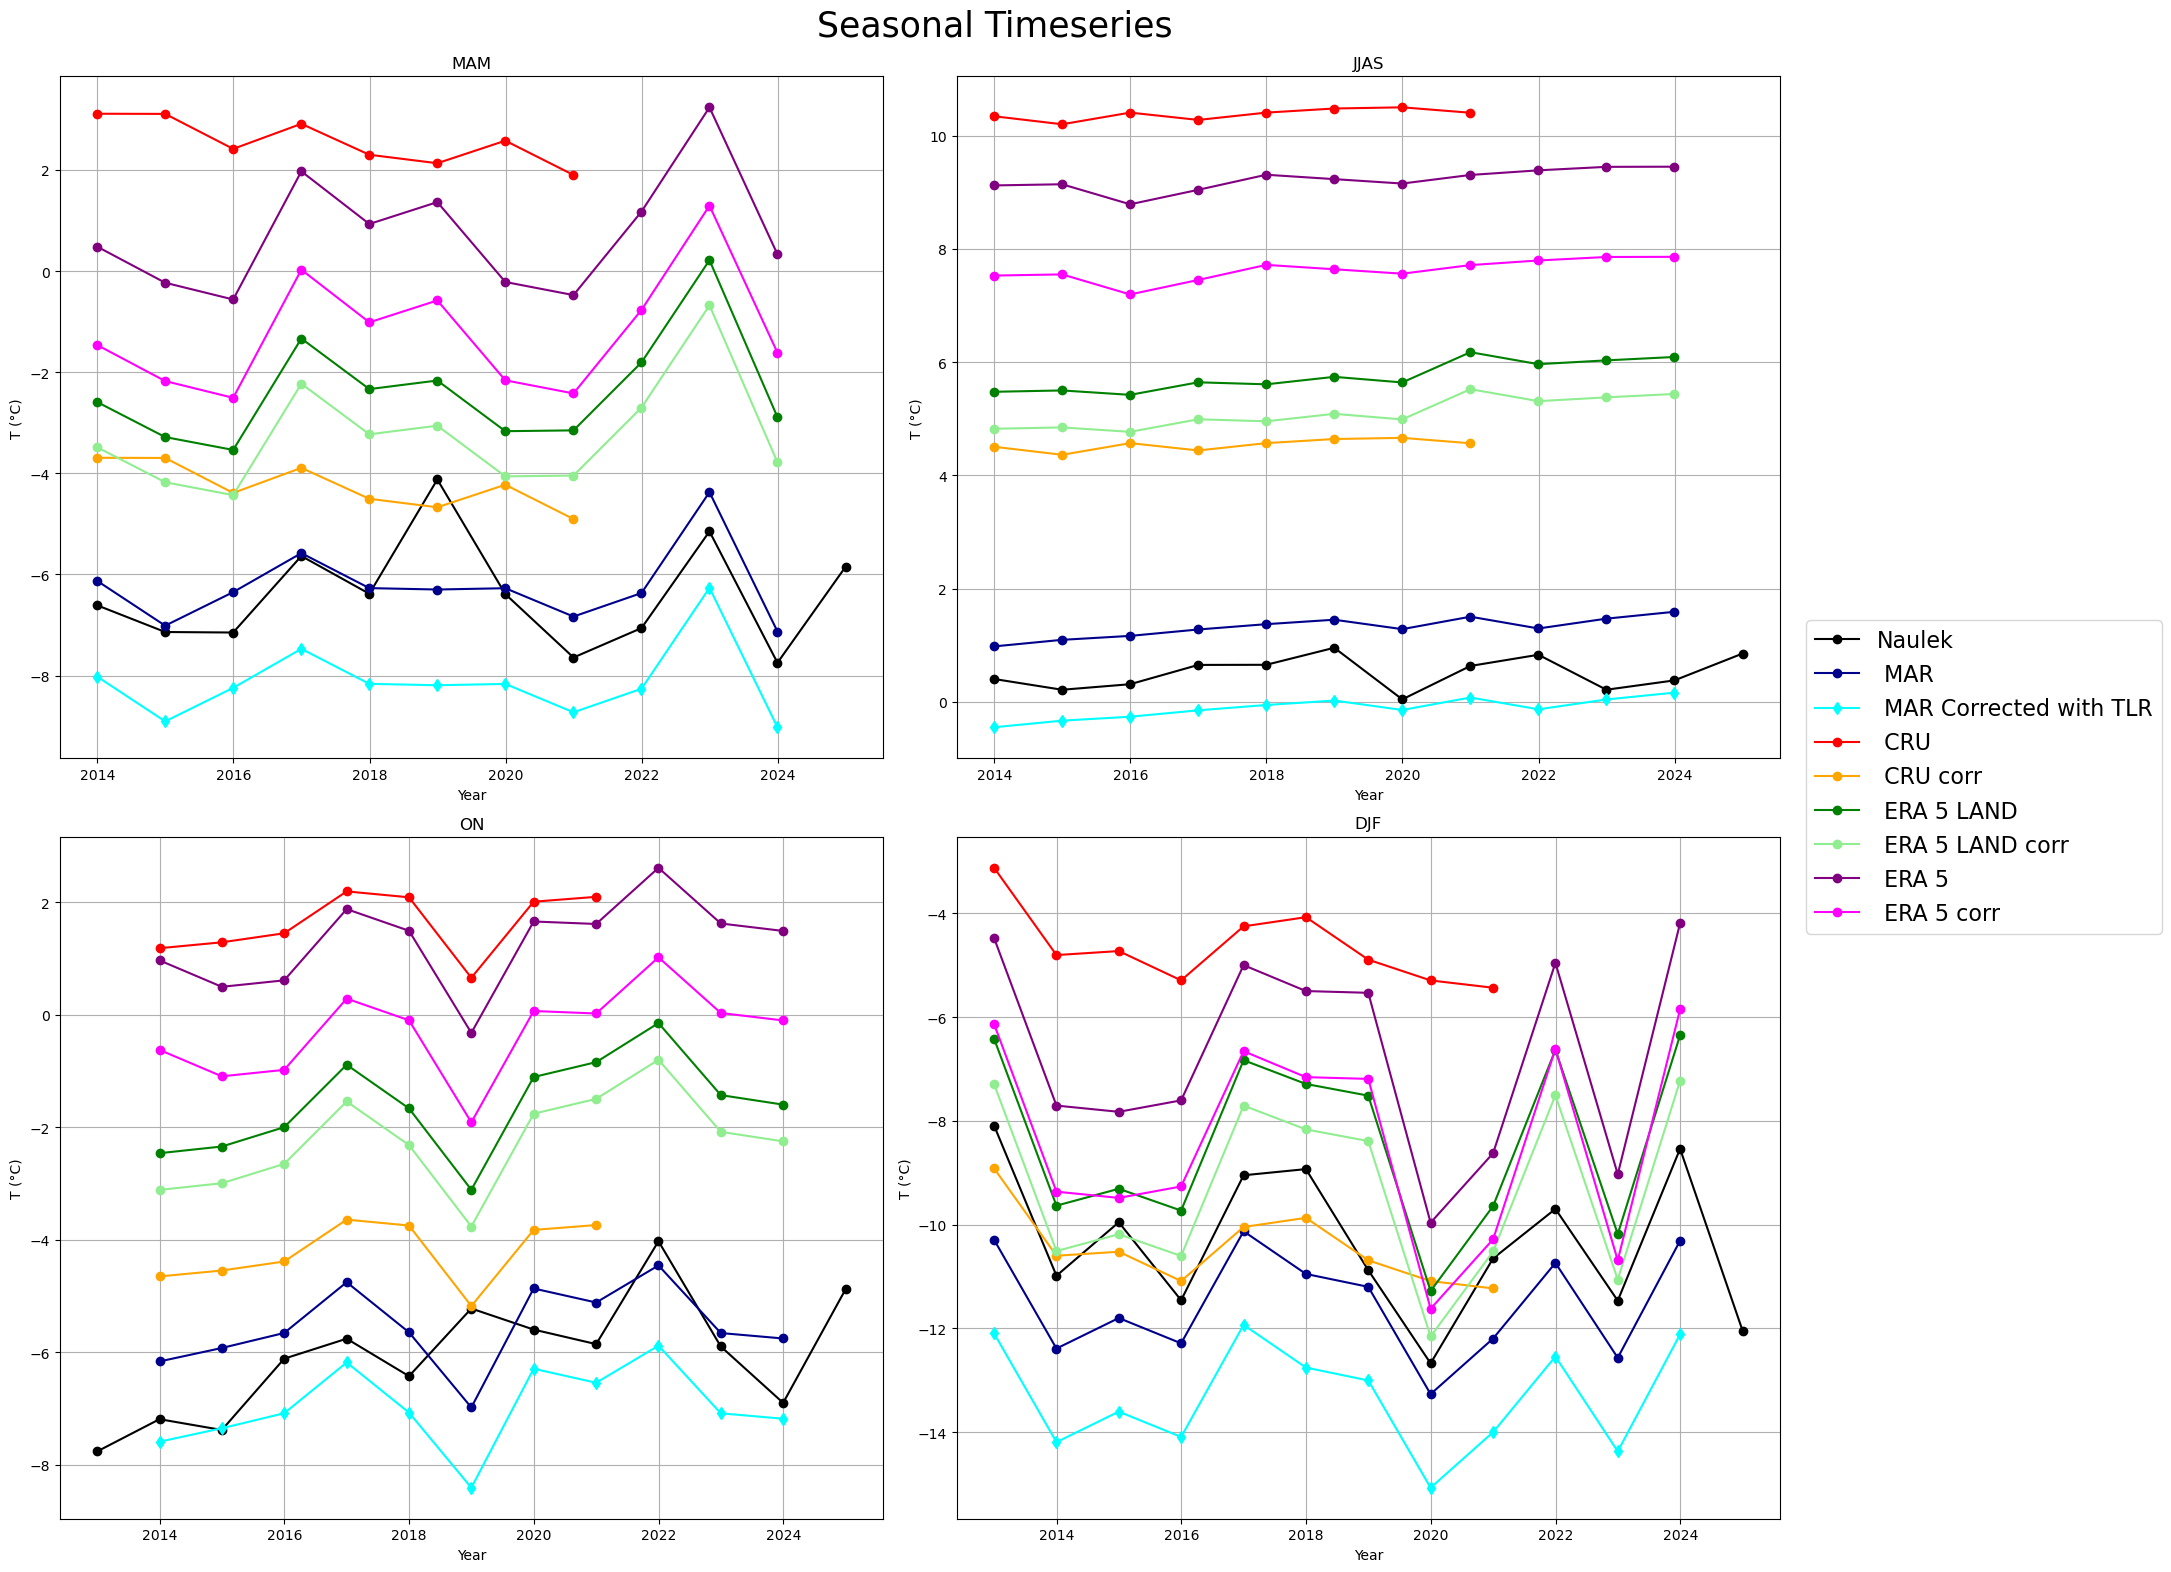

In [56]:
#Time Series
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

for thing, x in enumerate(seasons):
    ax = axes[thing]

    sta = seasonal_T_station['Tair'][x]
    # MAR
    mar = seasonnal_T_MAR[x]
    # MAR Corrected TLR
    mar_correction=seasonnal_T_MAR_corrected[x]
    #Cru
    cru= seasonnal_T_CRU[x]
    cru_correction=seasonnal_T_CRU_corrected[x]
    #ERA-5-LAND
    era5land=seasonnal_T_ERA_5_LAND[x]
    era5land_correction=seasonnal_T_ERA5_land_corrected[x]
    #ERA_5
    era5=seasonnal_T_ERA_5[x]
    era5_correction=seasonnal_T_ERA5_corrected[x]
    
    # Tracés
    ax.plot(sta.time, sta.values, linestyle='-', marker='o', label=station,color='black')
    ax.plot(mar.time, mar.values, linestyle='-', marker='o', label=' MAR',color='darkblue')
    ax.plot(mar_correction.time, mar_correction.values, linestyle='-', marker='d', label=' MAR Corrected with TLR',color='cyan')
    
    ax.plot(cru.time, cru.values, linestyle='-', marker='o', label=' CRU',color='red')
    ax.plot(cru_correction.time, cru_correction.values, linestyle='-', marker='o', label=' CRU corr',color='orange')

    ax.plot(era5land.time, era5land.values, linestyle='-', marker='o', label=' ERA 5 LAND',color='green')
    ax.plot(era5land_correction.time, era5land_correction.values, linestyle='-', marker='o', label=' ERA 5 LAND corr',color='lightgreen')
   
    ax.plot(era5.time, era5.values, linestyle='-', marker='o', label=' ERA 5',color='purple')
    ax.plot(era5_correction.time, era5_correction.values, linestyle='-', marker='o', label=' ERA 5 corr',color='fuchsia')

    # Mise en forme
    ax.set_title(titles[x])
    ax.set_xlabel('Year')
    ax.set_ylabel('T (°C)')
    ax.grid(True)
    #ax.legend()
handles, labels = axes[0].get_legend_handles_labels()
unique = dict(zip(labels, handles))

fig.legend(unique.values(), unique.keys(),loc='center left',bbox_to_anchor=(0.9, 0.5), fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.96])  # Laisser de l'espace à droite pour la légende
fig.suptitle('Seasonal Timeseries', fontsize=25)
plt.savefig("/home/rambaand/figs/" + station + "TimeSeries.png", dpi=300, bbox_inches='tight')

plt.show()


285.87256
5350.0


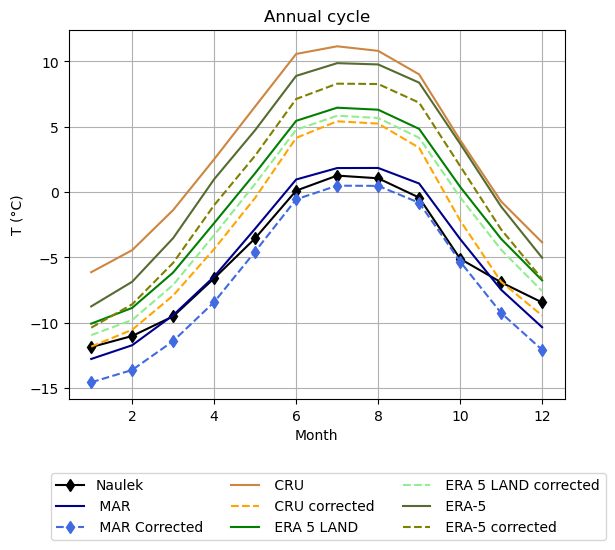

In [57]:
#Annual cycle 
#daily_meanRR=RR.resample(time='D').sum()  
T_cycle_sta=ClimBasis_T_station['monthly'].groupby('time.month').mean()


plt.plot(T_cycle_sta.month,T_cycle_sta.Tair,
        color='Black',linestyle='-',label=station,marker='d')
plt.plot(T_MAR_cycle.month,T_MAR_cycle.values,
         color='darkblue',linestyle='-',label=' MAR',marker='')

plt.plot(Corrected_T_MAR_cycle.month,Corrected_T_MAR_cycle.values,
         color='royalblue',linestyle='--',label=' MAR Corrected',marker='d')


plt.plot(T_CRU_Cycle.month,T_CRU_Cycle.values,
         color='peru',linestyle='-',label=' CRU',marker='')  

plt.plot(Corrected_T_CRU_Cycle.month,Corrected_T_CRU_Cycle.values,
         color='orange',linestyle='--',label=' CRU corrected',marker='')  



plt.plot(T_ERA_5_LAND_Cycle.month,T_ERA_5_LAND_Cycle.values,
         color='green',linestyle='-',label=' ERA 5 LAND',marker='')    

plt.plot(Corrected_T_ERA5_Land_Cycle.month,Corrected_T_ERA5_Land_Cycle.values,
         color='lightgreen',linestyle='--',label=' ERA 5 LAND corrected',marker='')    



plt.plot(T_ERA_5_Cycle.month,T_ERA_5_Cycle.values,
         color='darkolivegreen',linestyle='-',label=' ERA-5',marker='') 


plt.plot(Corrected_T_ERA5_Cycle.month,Corrected_T_ERA5_Cycle.values,
         color='olive',linestyle='--',label=' ERA-5 corrected',marker='') 


plt.legend(bbox_to_anchor=(-0.05, -0.4, 2, .3), ncol=3, loc='lower left')
plt.title('Annual cycle')
plt.xlabel('Month')
plt.ylabel('T (°C)')

plt.grid(True)
plt.savefig("/home/rambaand/figs/"+station+"annualcycle.png", dpi=300, bbox_inches='tight')

print(diff)
print(SH_sta)

285.87256
5350.0


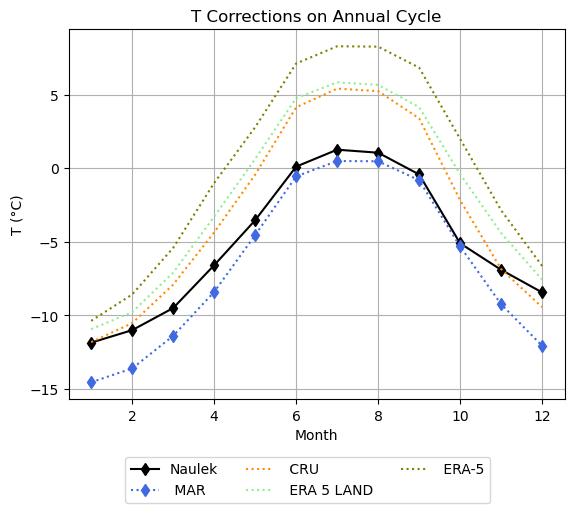

In [58]:
#Annual cycle 
#daily_meanRR=RR.resample(time='D').sum()  
T_cycle_sta=ClimBasis_T_station['monthly'].groupby('time.month').mean()


plt.plot(T_cycle_sta.month,T_cycle_sta.Tair,
        color='Black',linestyle='-',label=station,marker='d')
plt.plot(Corrected_T_MAR_cycle.month,Corrected_T_MAR_cycle.values,
         color='royalblue',linestyle=':',label=' MAR',marker='d')



plt.plot(T_CRU_Cycle.month,Corrected_T_CRU_Cycle.values,
         color='darkorange',linestyle=':',label=' CRU',marker='')  


plt.plot(T_ERA_5_LAND_Cycle.month,Corrected_T_ERA5_Land_Cycle.values,
         color='lightgreen',linestyle=':',label=' ERA 5 LAND',marker='')    

plt.plot(T_ERA_5_Cycle.month,Corrected_T_ERA5_Cycle.values,
         color='olive',linestyle=':',label=' ERA-5',marker='') 

#plt.text(1,5.5,'Biais', color='r')

plt.legend(bbox_to_anchor=(0.1, -0.3, 2, .3), ncol=3, loc='lower left')
plt.title('T Corrections on Annual Cycle')
plt.xlabel('Month')
plt.ylabel('T (°C)')
plt.grid(True)
plt.savefig("/home/rambaand/figs/"+station+"annualcycleCorrected.png", dpi=300, bbox_inches='tight')


print(diff)
print(SH_sta)

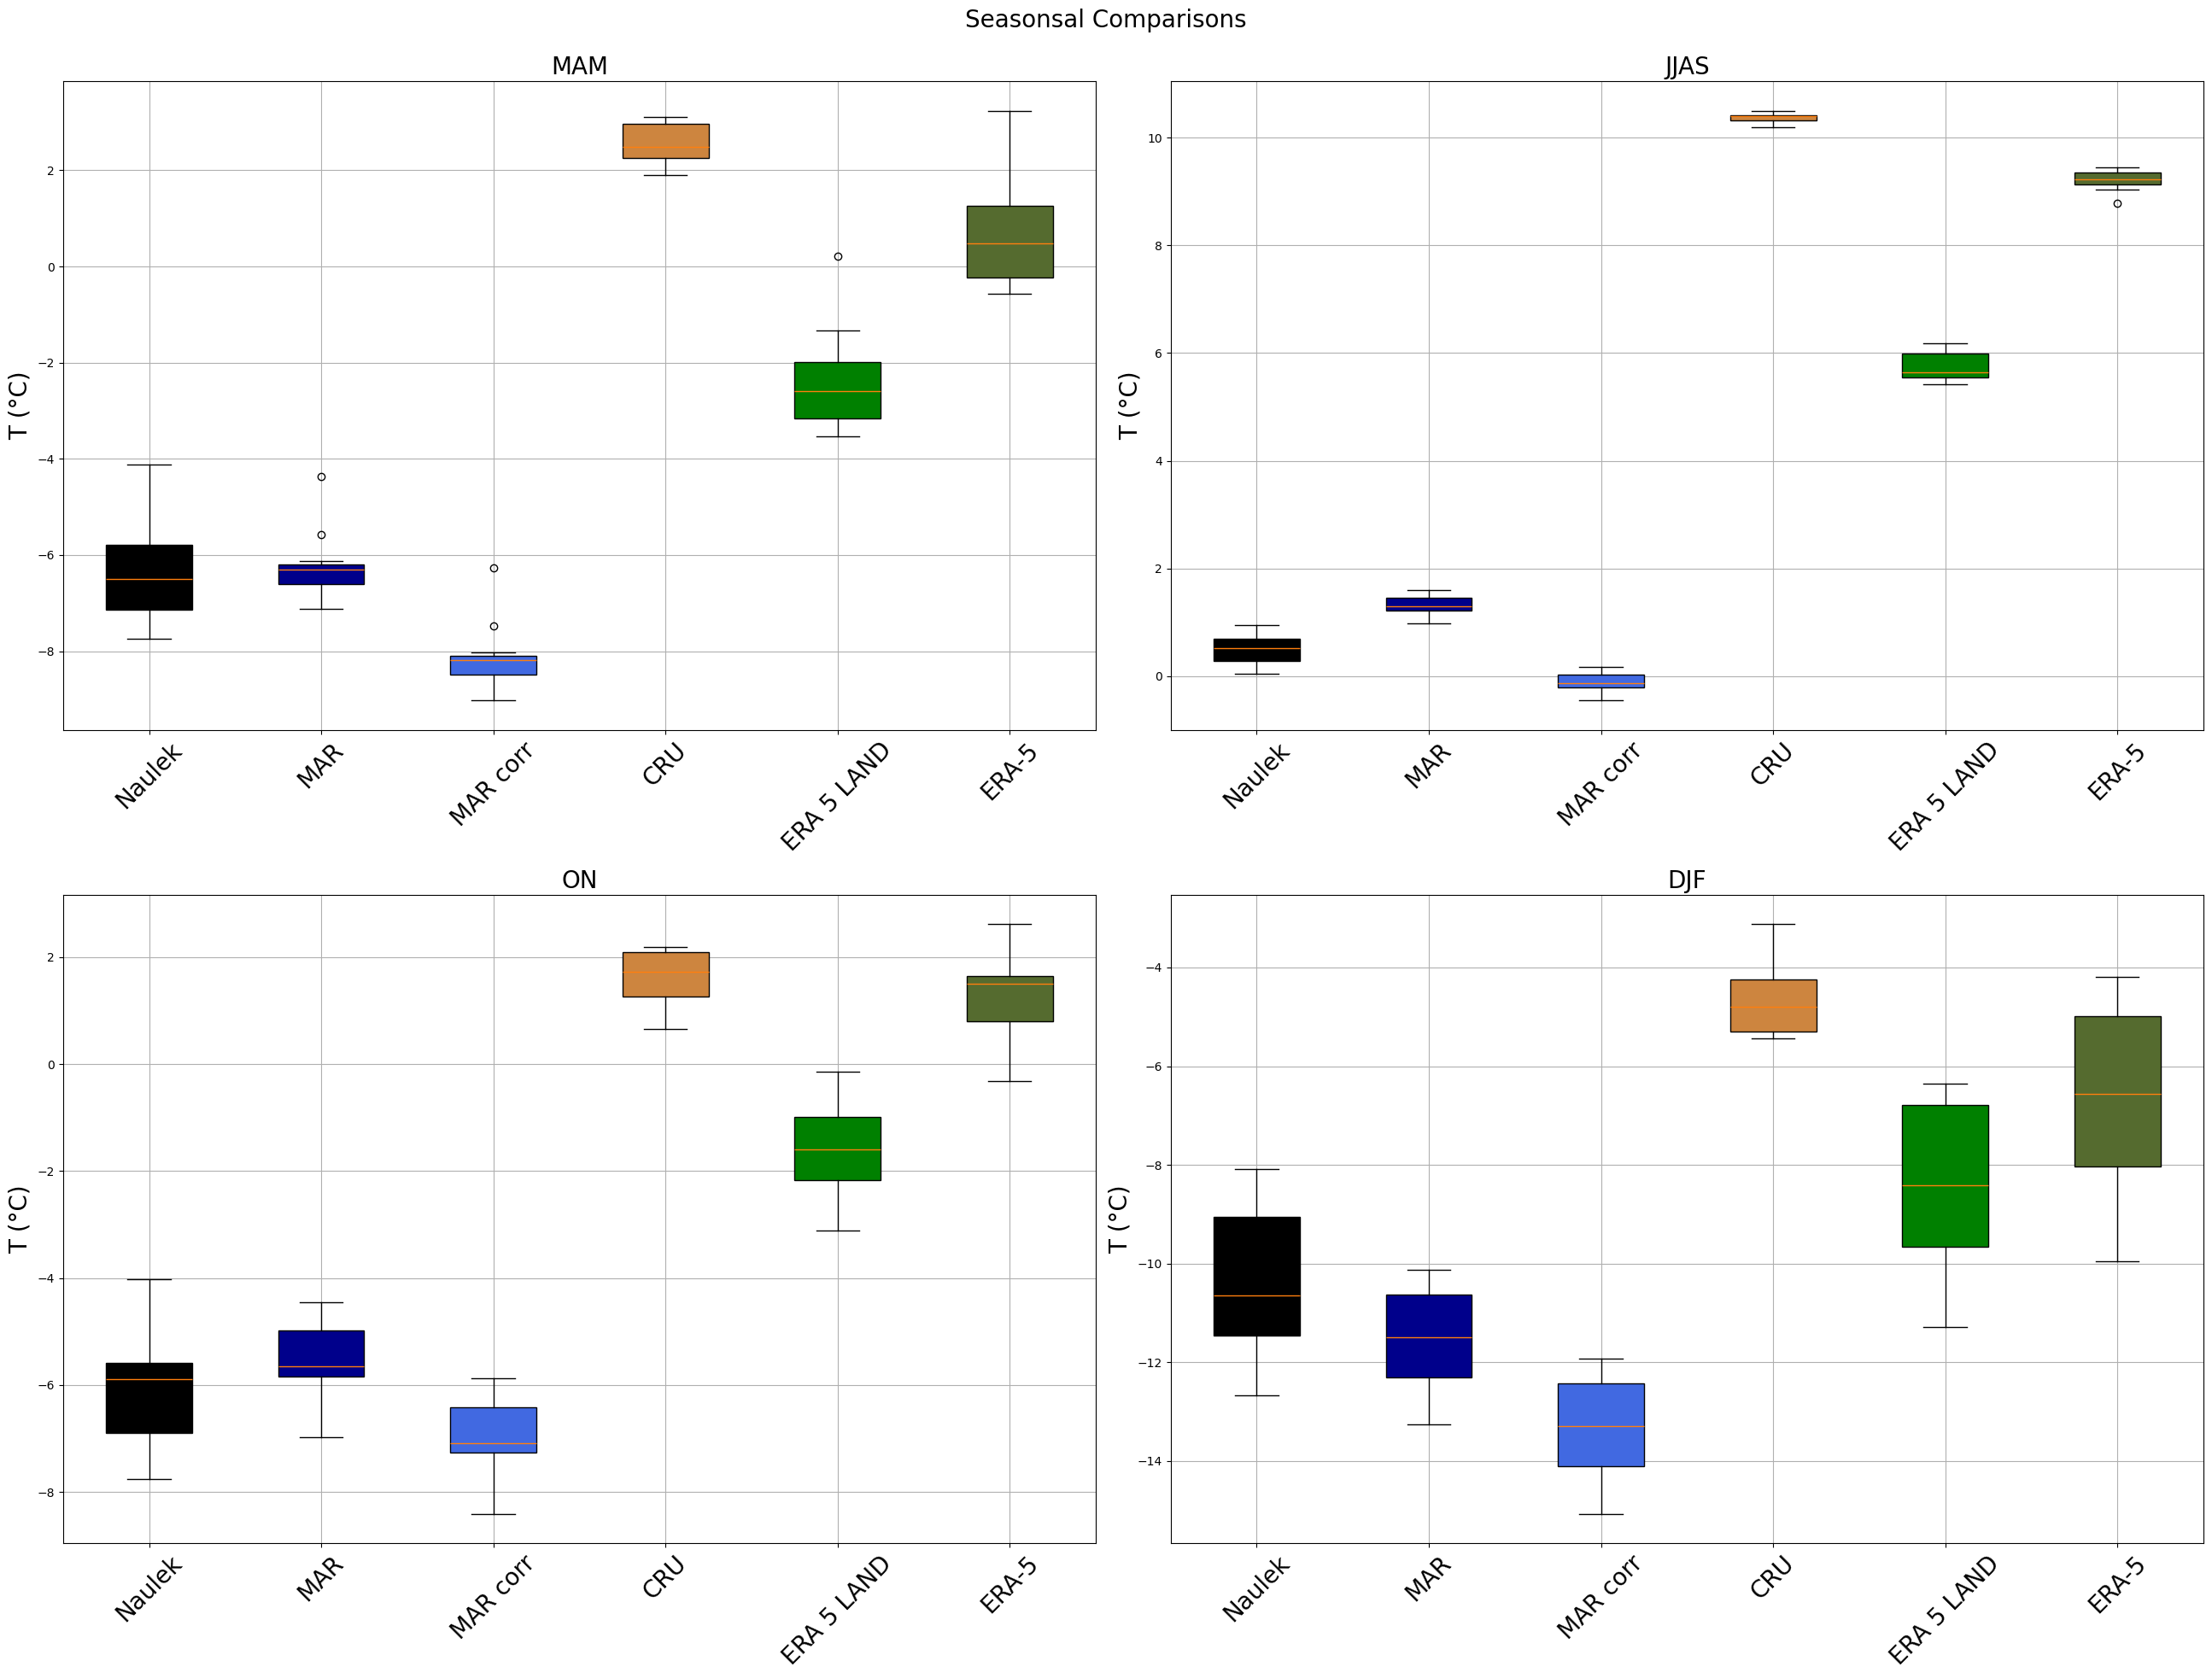

In [59]:
#


fig, axes = plt.subplots(2, 2, figsize=(26, 20))
axes = axes.flatten()

for things, x in enumerate(seasons):
    ax = axes[things]

    sta = seasonal_T_station['Tair'][x]
    # MAR
    mar = seasonnal_T_MAR[x]
    # MAR Corrected TLR
    mar_correction=seasonnal_T_MAR_corrected[x]
    #Cru
    cru= seasonnal_T_CRU[x] 
    #ERA-5-LAND
    era5land=seasonnal_T_ERA_5_LAND[x]
    #ERA_5
    era5=seasonnal_T_ERA_5[x]


    
    # listes
    data = [sta, mar,mar_correction,  cru,era5land,era5]
    
    tick_labels = [station, 'MAR','MAR corr',  'CRU','ERA 5 LAND', 'ERA-5']
    colors = ['black', 'darkblue','royalblue', 'peru','green','darkolivegreen']
    
    
    bp = ax.boxplot(data, patch_artist=True, tick_labels=tick_labels)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        
    ax.set_title(titles[x],fontsize=20)
    ax.set_ylabel('T (°C)',fontsize=20)
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45,labelsize=20)
    ax.legend
plt.tight_layout(rect=[0, 0, 1, 0.96])
fig.suptitle('Seasonsal Comparisons', fontsize=20)
plt.savefig("/home/rambaand/figs/"+station+"boxplot.png", dpi=300, bbox_inches='tight')

plt.show()


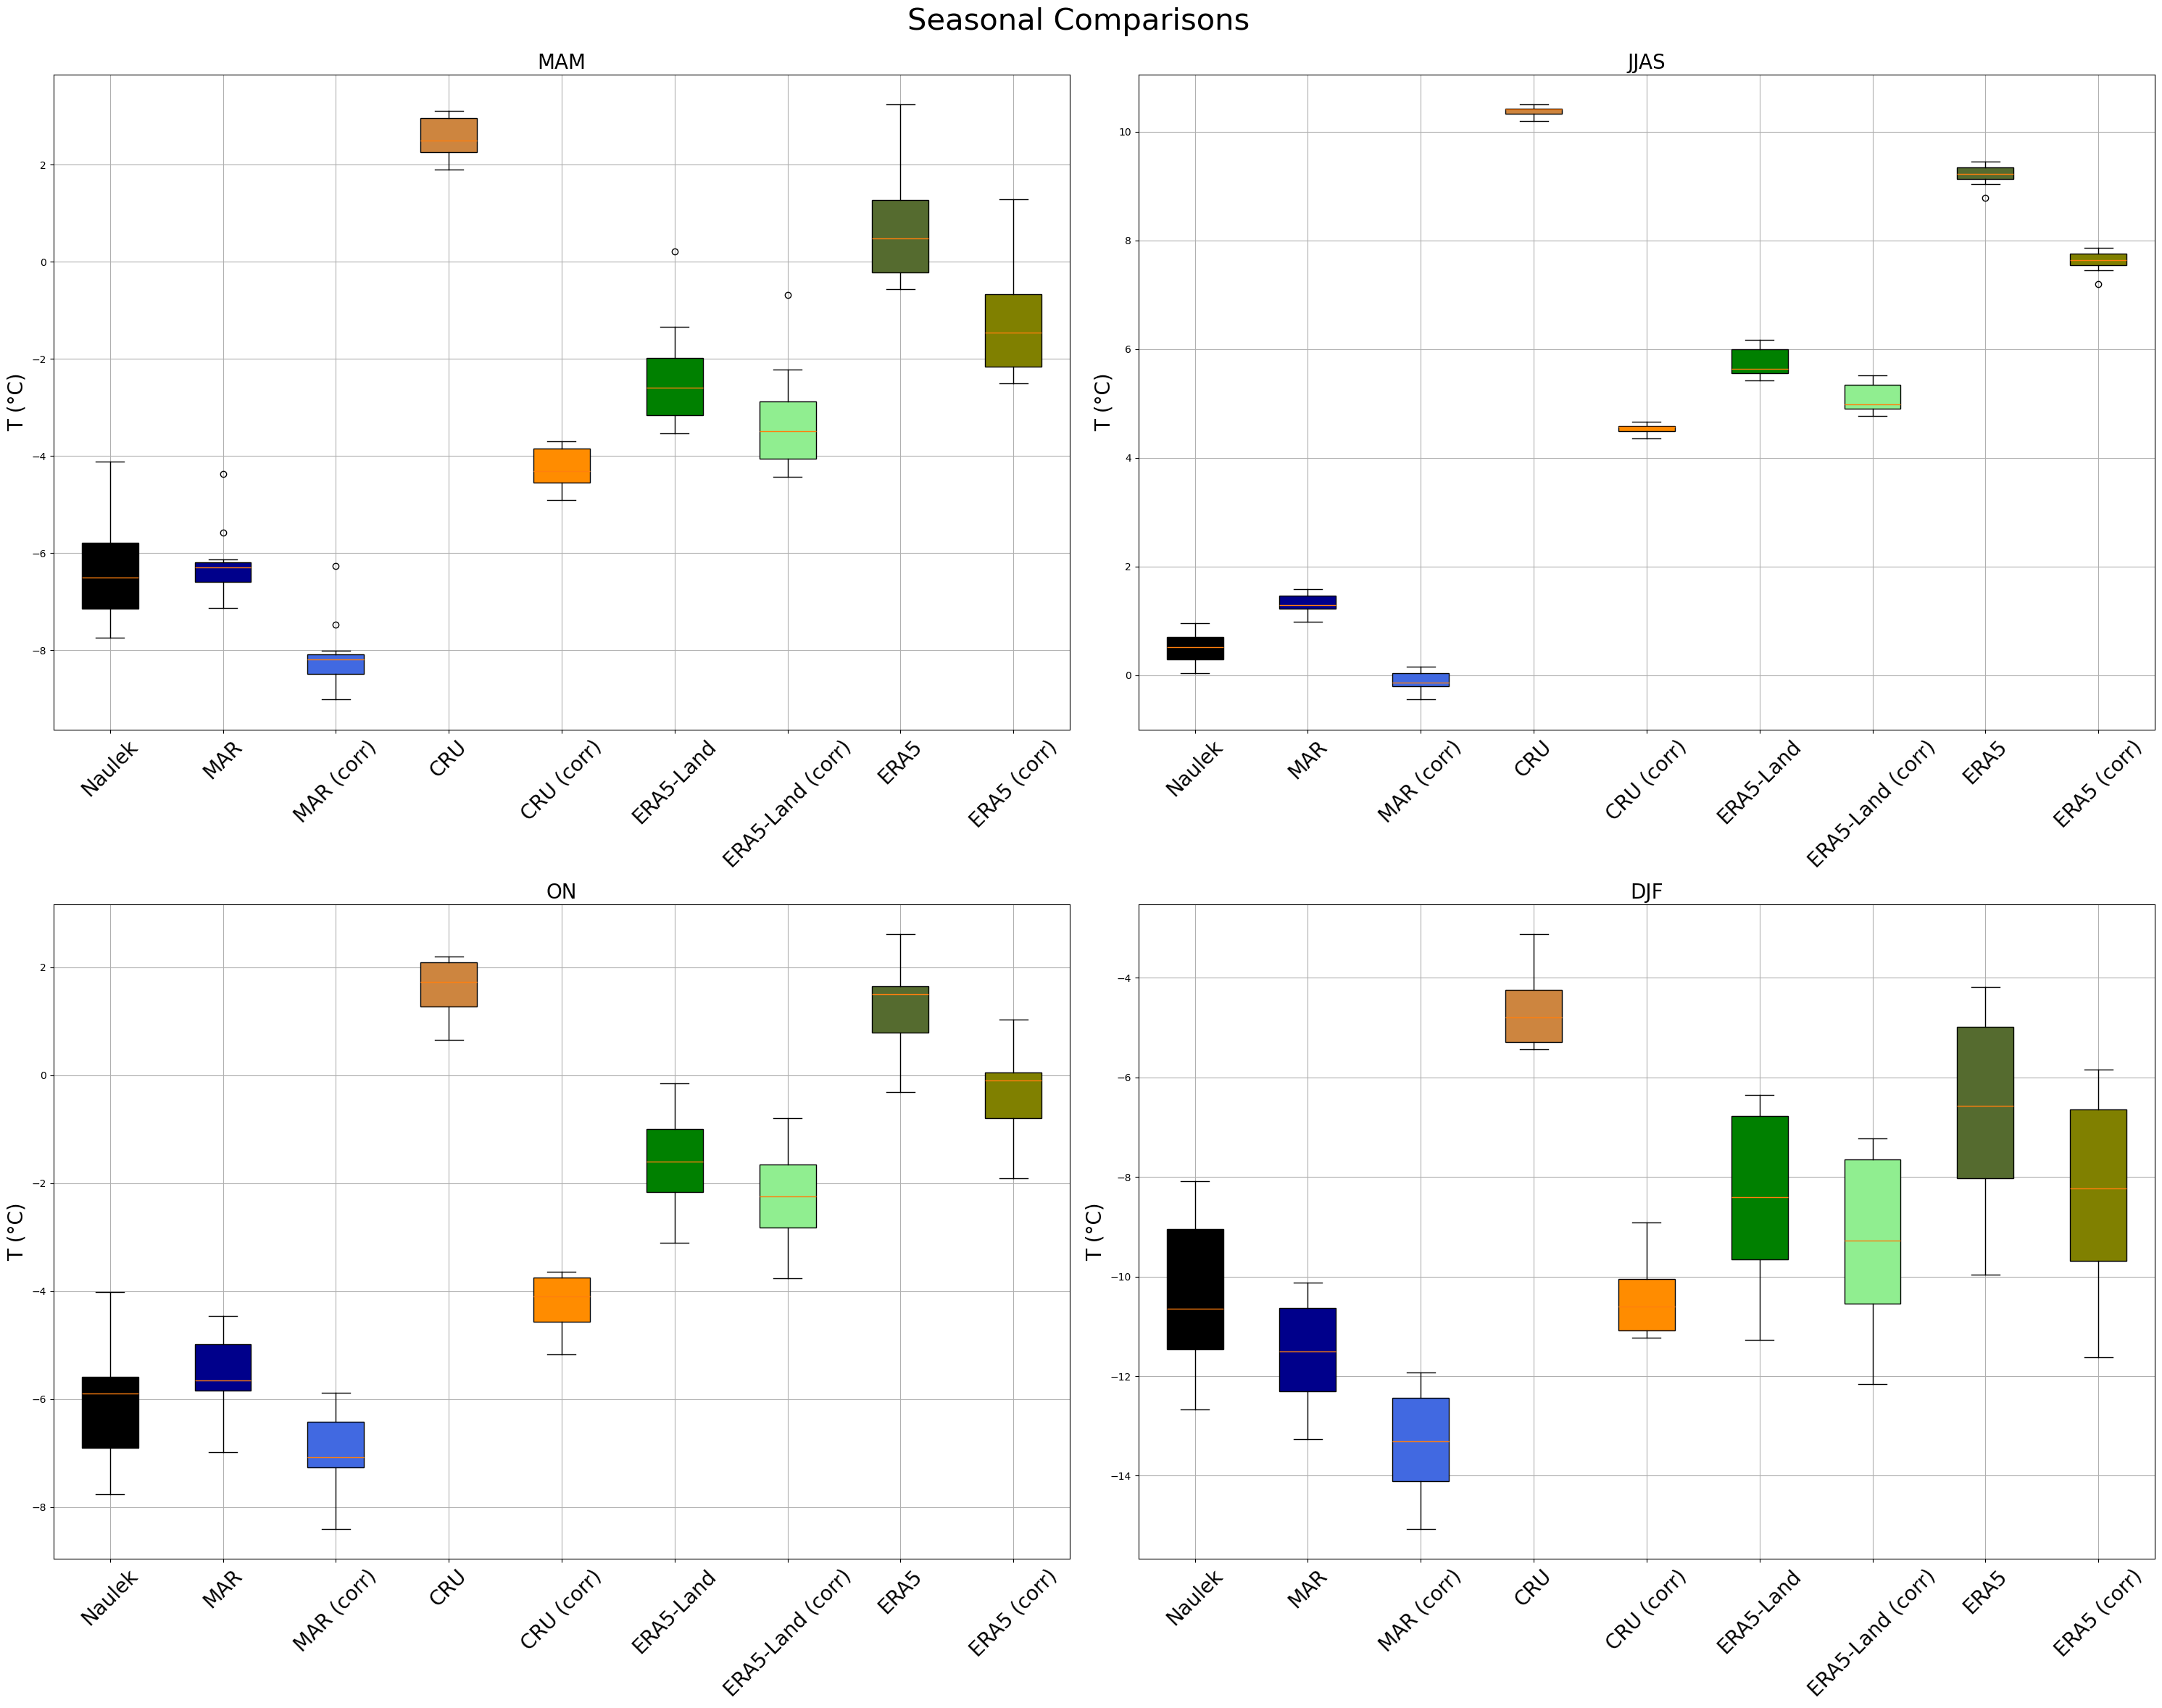

In [60]:

fig, axes = plt.subplots(2, 2, figsize=(30, 24))
axes = axes.flatten()

for idx, season in enumerate(seasons):
    ax = axes[idx]
    
    # Data
    sta = seasonal_T_station['Tair'][season]
    mar = seasonnal_T_MAR[season]
    mar_corr = seasonnal_T_MAR_corrected[season]
    
    cru = seasonnal_T_CRU[season]
    cru_corr = seasonnal_T_CRU_corrected[season]
    
    era5land = seasonnal_T_ERA_5_LAND[season]
    era5land_corr = seasonnal_T_ERA5_land_corrected[season]
    
    era5 = seasonnal_T_ERA_5[season]
    era5_corr = seasonnal_T_ERA5_corrected[season]
    
    # Dic pour boxplot
    data = [
        sta, 
        mar, mar_corr, 
        cru, cru_corr, 
        era5land, era5land_corr, 
        era5, era5_corr
    ]

    tick_labels = [
        station,
        'MAR', 'MAR (corr)',
        'CRU', 'CRU (corr)',
        'ERA5-Land', 'ERA5-Land (corr)',
        'ERA5', 'ERA5 (corr)'
    ]
    
    colors = [
        'black',
        'darkblue', 'royalblue',
        'peru', 'darkorange',
        'green', 'lightgreen',
        'darkolivegreen', 'olive'
    ]
    
    # Boxplot
    bp = ax.boxplot(data, patch_artist=True, tick_labels=tick_labels)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_title(titles[season],fontsize=20)
    ax.set_ylabel('T (°C)',fontsize=20)
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45,labelsize=20)
    
plt.tight_layout(rect=[0, 0, 1, 0.96])
fig.suptitle('Seasonal Comparisons ', fontsize=30)
plt.savefig("/home/rambaand/figs/"+station+"boxplotcorr.png", dpi=300, bbox_inches='tight')

plt.show()


fig, axes = plt.subplots(2, 2, figsize=(22, 16))
axes = axes.flatten()

group_labels = ['Station', 'MAR', 'CRU', 'ERA5-Land', 'ERA5']

for idx, season in enumerate(seasons):
    ax = axes[idx]

    # Data
    sta = seasonal_T_station['Tair'][season]

    mar = seasonnal_T_MAR[season]
    mar_corr = seasonnal_T_MAR_corrected[season]

    cru = seasonnal_T_CRU[season]
    cru_corr = seasonnal_T_CRU_corrected[season]

    era5land = seasonnal_T_ERA_5_LAND[season]
    era5land_corr = seasonnal_T_ERA5_land_corrected[season]

    era5 = seasonnal_T_ERA_5[season]
    era5_corr = seasonnal_T_ERA5_corrected[season]

    #Plot
    bp_sta = ax.boxplot([sta], positions=[1.0], widths=0.3, patch_artist=True)
    bp_sta['boxes'][0].set_facecolor('black')
    #liste data pour plot
    data_raw = [mar, cru, era5land, era5]
    data_corr = [mar_corr, cru_corr, era5land_corr, era5_corr]
    #Position avec Sta centrée puis le reste 2 à 2 
    base_positions = np.arange(2, 6)  
    positions_raw = base_positions - 0.15
    positions_corr = base_positions + 0.15

    colors_raw = ['darkblue', 'peru', 'green', 'darkolivegreen']
    colors_corr = ['royalblue', 'darkorange', 'lightgreen', 'olive']

    # Tracé
    bp_raw = ax.boxplot(data_raw, positions=positions_raw, widths=0.25, patch_artist=True)
    bp_corr = ax.boxplot(data_corr, positions=positions_corr, widths=0.25, patch_artist=True)

    for patch, color in zip(bp_raw['boxes'], colors_raw):
        patch.set_facecolor(color)
    for patch, color in zip(bp_corr['boxes'], colors_corr):
        patch.set_facecolor(color)

    ax.set_xticks(np.arange(1, 6))
    ax.set_xticklabels(group_labels, rotation=45)
    ax.set_title(titles[season])
    ax.set_ylabel('T (°C)')
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
fig.suptitle('Seasonal Comparisons', fontsize=20)
plt.show()



###########
## RMSE ## et correlation per season.
###########




#Enlever Cru parce que 1 moins moins pertinent 2 enlève des années de data et era 5/land plus intéressants ? 



seasonal_T_stationtime2= seasonal_T_station['Tair']['JJAS'].sel(time=slice('2014','2020')) 

ProductList=[seasonnal_T_MAR['JJAS'],seasonnal_T_MAR_corrected['JJAS'],seasonnal_T_CRU['JJAS'],seasonnal_T_CRU_corrected['JJAS'],
             seasonnal_T_ERA_5_LAND['JJAS'],seasonnal_T_ERA5_land_corrected['JJAS'],seasonnal_T_ERA_5['JJAS'],
             seasonnal_T_ERA5_corrected['JJAS']]
ProductLisT2015= [ds.sel(time=slice('2014','2020')) for ds in ProductList]


corrList=[]
rmseList=[]
for i in range(len(ProductList)):
    tmp=np.corrcoef(seasonal_T_stationtime2.values,ProductLisT2015[i].values)[0,1]
    rmse = np.sqrt(np.nanmean((seasonal_T_stationtime2.values - ProductLisT2015[i].values)**2))
    corrList.append(round(tmp,2))
    rmseList.append(round(rmse,2))



labels = ["MAR", "MARc", "CRU", "CRUc", "ERA5land", "ERA5landc", "ERA5", "ERA5c"]

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(corrList, rmseList, marker="x")

# Add experiment labels next to each point
for x, y, label in zip(corrList, rmseList, labels):
    ax.text(x, y, label, fontsize=9, ha="right", va="bottom")

ax.set_xlabel("Correlation")
ax.set_ylabel("RMSE")
ax.set_title("RMSE vs Correlation MeraLa (JJAS) ")
ax.grid(True)
fig.tight_layout()


